In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %cd /content/drive/My Drive/Research Project

/content/drive/My Drive/Research Project


In [1]:
import pandas as pd
import numpy as np
import os
# import src
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# pip install -U mittens

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from statistics import mean, stdev, median, mode
# With PCA
from sklearn.decomposition import PCA

from sklearn.feature_extraction.text import CountVectorizer
# SVM
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from mittens import GloVe, Mittens

In [3]:
# pip install autocorrect

In [7]:

import nltk
import string
from nltk.tokenize import word_tokenize
import random
import pickle
from nltk.corpus import stopwords

from autocorrect import Speller
# from pycontractions import Contractions

# from spellchecker import SpellChecker

import re
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer 

from hyperopt import fmin, tpe, hp

In [8]:
# nltk.download('all')

In [9]:
from numpy import asarray
from numpy import zeros
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [10]:
# nltk.download('all')

In [ ]:
# # Load your favorite word2vec model
# cont = Contractions('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz')
# text = "we're"
# text = list(cont.expand_texts([text], precise=True))[0]

In [ ]:
def conv_dataframes(pos_path, neg_path):
    with open(pos_path,'r',encoding='latin1') as f:
        data_p = f.readlines()
#     print(data_p[11])
    with open(neg_path,'r',encoding='latin1') as f:
        data_n = f.readlines()
    pos_data = shuffle(pd.DataFrame(data_p, columns = ["Doc Text"]))
#     pos_data['Sentiment'] = 1
#     pos_data.columns = ["Doc Text", "Sentiment"]
    neg_data = shuffle(pd.DataFrame(data_n, columns = ["Doc Text"]))
#     neg_data['Sentiment'] = -1
#     neg_data.columns = ["Doc Text", "Sentiment"]
    return pos_data, neg_data


## The code for pos tagging and lemmatize sentence is fron the following link:
 ### https://medium.com/@gaurav5430/using-nltk-for-lemmatizing-sentences-c1bfff963258

In [ ]:
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [ ]:
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
#     print(wordnet_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
#         if tag is not None:
#             lemmatized_sentence.append(lemmatizer.lemmatize(word, tag)) 

    return " ".join(lemmatized_sentence)

In [ ]:
# print(lemmatizer.lemmatize("I am loving it")) #I am loving it
# print(lemmatizer.lemmatize("loving")) #loving
# print(lemmatizer.lemmatize("loving", "v")) #love
# print(lemmatize_sentence("I am loving it")) #I be love it

In [ ]:
def text_preprocessing(data):
    
    # This method replaces two or more consecutive letters with the same character to something shorter. For example, gooooooood becomes good.
    def replaceTwoOrMore(s):
        #look for 2 or more repetitions of character
        pattern = re.compile(r"(.)\1{1,}", re.DOTALL) 
        return pattern.sub(r"\1\1", s)

    # This method converts camel cased words into space delimited words.
    # For example: ThisIsASentence will be changed to This Is A Sentence
    def convertCamelCase(word):
        return re.sub("([a-z])([A-Z])","\g<1> \g<2>",word)

    # Read a flat file containing some abbreviations and their expansions in pipe separated format
    # Use these abbreviations to replace text in the tweets as part of Preprocessing
    
    def readAbbrFile(abb_path):
        global abbr_dict
        abbr_dict ={}
        f = open(abb_path)
        lines = f.readlines()
        f.close()
        for i in lines:
            tmp = i.split('|')
            abbr_dict[tmp[0]] = tmp[1]

        return abbr_dict
  
    # This function checks the dictionary containing abbreviations and their meanings as (key,value) pairs
    # and replaces the key with the corresponding value
    def replaceAbbr(s):
#         temp =[]
#         for word in s.split():
#             if word.lower() in abbr_dict.keys():
# #                 print('t')                
#                 temp.append(abbr_dict[word.lower()])
#             else:
#                 temp.append(word)
        temp = " ".join([abbr_dict[word.lower()] if word.lower() in abbr_dict.keys() else word for word in s.split()])
        return temp
    #end

    def readcontractions(contra_path):
        global contra_dict
        contra_dict ={}
        f = open(contra_path)
        lines = f.readlines()
        f.close()
        for i in lines:
            try: 
                tmp = i.replace('"', '').replace(',', '').replace('\n', ' ').split(':')
                contra_dict[tmp[0]] = tmp[1]
            except:
                print(tmp)
                print(z)

        return contra_dict
    
    # This function checks the dictionary containing abbreviations and their meanings as (key,value) pairs
    # and replaces the key with the corresponding value
    def replacecontra(s):
        temp = " ".join([contra_dict[word.lower()] if word.lower() in contra_dict.keys() else word for word in s.split()])
        return temp
    #end    
    

    abb_path = os.path.join(data_path,"abbrevations.txt")
    abbr_dict = readAbbrFile(abb_path)
    
    contra_path = os.path.join(data_path,"contractions.txt")
    contra_dict = readcontractions(contra_path)
    
    data["Doc Text"] = data["Doc Text"].apply(lambda x: x.lower())
    data["Doc Text"] = data["Doc Text"].apply(lambda x: replaceAbbr(x))
    data["Doc Text"] = data["Doc Text"].apply(lambda x: replacecontra(x))

    data["Doc Text"] = data["Doc Text"].str.replace('\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*',' ') #remove URL
    data["Doc Text"] = data["Doc Text"].str.replace('(\s)@\w+', ' ') #remove usernames
    data["Doc Text"] = data["Doc Text"].str.replace('@\w+', ' ') #remove usernames
    data["Doc Text"] = data["Doc Text"].str.replace('<[^<]+?>', ' ') #remove HTML tags
    data["Doc Text"] = data["Doc Text"].str.replace('[<>!#@$:.,%\?-]+', ' ') #remove punctuation and special characters
    
    data["Doc Text"] = data["Doc Text"].str.replace('\d+', ' ') # removing the words with more than 1 digit
    data["Doc Text"] = data["Doc Text"].str.replace('\n\n', ' ')
    data["Doc Text"] = data["Doc Text"].str.replace('\n', ' ') # removing new line characters
    data["Doc Text"] = data["Doc Text"].str.replace('[^\w\s]',' ')
#     data["Doc Text"] = data["Doc Text"].str.replace('\s+[a-zA-Z]\s+',' ')
#     data["Doc Text"] = data["Doc Text"].str.replace('\^[a-zA-Z]\s+',' ')
    data["Doc Text"] = data["Doc Text"].str.replace('\s+',' ')  

    
    data["Doc Text"] = data["Doc Text"].apply(lambda x: replaceTwoOrMore(x))
    data["Doc Text"] = data["Doc Text"].apply(lambda x: convertCamelCase(x))

    # Remove stop words from text
    data["Doc Text"] = data["Doc Text"].apply(lambda x: " ".join([word for word in x.split() if word not in stop_list]))
    
#     data["Doc Text"] = data["Doc Text"].apply(lambda x: " ".join([lemmatizer.lemmatize(y) for y in x.split()]))
    data["Doc Text"] = data["Doc Text"].apply(lambda x: lemmatize_sentence(x))

    return data

In [ ]:
st = 'k k  k'
st.replace('\s+','')
st.replace('\n\n', '')
st.replace('[^\w\s]','')
st.replace('\s+[a-zA-Z]\s+','')
st.replace('\^[a-zA-Z]\s+','')

'k k  k'

In [ ]:
def create_vocab(data1, data2):
    temp1 = text_preprocessing(data1)
    temp2 = text_preprocessing(data2)
#     temp_pos2 = np.asarray([word_tokenize(re.sub(r"\b[a-zA-Z]\b", " ",i)) for i in temp_pos['Doc Text']])
#     temp_neg2 = np.asarray([word_tokenize(re.sub(r"\b[a-zA-Z]\b", " ",i)) for i in temp_neg['Doc Text']]) 
#     temp_pos["Doc Text Tokens"] = temp_pos2 
#     temp_neg["Doc Text Tokens"] = temp_neg2
    return temp1, temp2

In [ ]:
data_path = r'C:\Users\kalya\OneDrive - University of Illinois at Chicago\!UIC\!Semesters\3rd Sem\CS 583 Data Mining and Text Mining\Research Project\Data'

In [ ]:

trainFile = os.path.join(data_path,"training-Obama-Romney-tweets.xlsx")
obama_train_temp = pd.read_excel(trainFile, sheet_name = 'Obama', header = None, skiprows =[0,1], usecols= [3,4], names =['Doc Text', 'Sentiment'])
romney_train_temp = pd.read_excel(trainFile, sheet_name = 'Romney', header = None, skiprows =[0,1], usecols= [3,4], names =['Doc Text', 'Sentiment'])



FileNotFoundError: ignored

In [ ]:
obama_train_temp.head()

In [ ]:
romney_train_temp.head()

## Removing datapoints with mixed sentiment

In [ ]:
obama_train = obama_train_temp[obama_train_temp['Sentiment'] .isin((1,-1,0))]
obama_train.head()

In [ ]:
romney_train = romney_train_temp[romney_train_temp['Sentiment'] .isin((1,-1,0))]
romney_train.head()

# Dropping missing values

In [ ]:
obama_train = obama_train.dropna()
romney_train = romney_train.dropna()

## Data Analysis

In [ ]:
obama_train_DA = obama_train['Sentiment'].value_counts()
obama_train_DA

-1    1922
 0    1895
 1    1653
Name: Sentiment, dtype: int64

<BarContainer object of 3 artists>

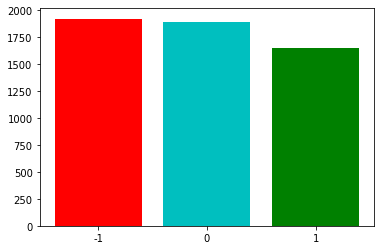

In [ ]:
plt.bar(height = obama_train_DA, x = ['-1', '0', '1'], color = ['r', 'c', 'g'])

In [ ]:
romney_train_DA = romney_train['Sentiment'].value_counts()
romney_train_DA

-1    2893
 0    1680
 1    1075
Name: Sentiment, dtype: int64

<BarContainer object of 3 artists>

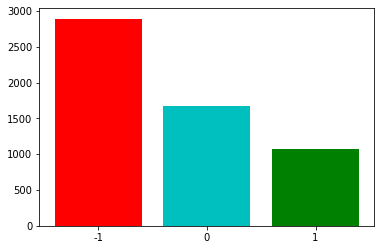

In [ ]:
plt.bar(height = romney_train_DA, x = ['-1', '0', '1'], color = ['r', 'c', 'g'])

# Romney data is very imbalanced
# So, its better to select the best model with respect to F1 Score

## Preprocessing the data

In [ ]:
# hm_lines = 5331

# tokenizer = nltk.RegexpTokenizer(r"\w+")
# spell = Speller(lang='en')
# # spell = SpellChecker()

# stop_words = set(stopwords.words('english'))
stop_list = stopwords.words('english')
stop_list.extend(['rt', 'retweet', 'e'])

lemmatizer = WordNetLemmatizer() 

In [ ]:
obama_train_pr, romney_train_pr = create_vocab(obama_train, romney_train)

In [ ]:
obama_train_pr.head()

,Doc Text,Sentiment
0,kirkpatrick wear baseball cap embroider obama ...,0
2,obama debate cracker as cracker tonight tune t...,1
4,miss point afraid understand big picture dont ...,0
6,raise democrat leave party year ago lifetime n...,-1
7,obama camp can not afford low expectation toni...,0


In [ ]:
obama_train_pr['Sentiment'] = obama_train_pr['Sentiment'].apply(lambda x: 'Positive' if x == 1 else ('Negative' if x == -1 else 'Neutral'))

In [ ]:
obama_train_pr.head()

,Doc Text,Sentiment
0,kirkpatrick wear baseball cap embroider obama ...,Neutral
2,obama debate cracker as cracker tonight tune t...,Positive
4,miss point afraid understand big picture dont ...,Neutral
6,raise democrat leave party year ago lifetime n...,Negative
7,obama camp can not afford low expectation toni...,Neutral


In [ ]:
romney_train_pr.head()

,Doc Text,Sentiment
0,insidious mitt romney bain help philip morris ...,-1
2,mean like romney cheat primary,-1
3,mitt romney still believe black president,-1
4,romney tax plan deserve nd look secret one dif...,-1
5,hope romney debate prepped people last time,1


In [ ]:
romney_train_pr['Sentiment'] = romney_train_pr['Sentiment'].apply(lambda x: 'Positive' if x == 1 else ('Negative' if x == -1 else 'Neutral'))

In [ ]:
romney_train_pr.head()

,Doc Text,Sentiment
0,insidious mitt romney bain help philip morris ...,Negative
2,mean like romney cheat primary,Negative
3,mitt romney still believe black president,Negative
4,romney tax plan deserve nd look secret one dif...,Negative
5,hope romney debate prepped people last time,Positive



## Building Machine Learning Models

In [ ]:
# obama_train_pr.to_csv(os.path.join(data_path, 'Obama Training1 Data.csv'))
# romney_train_pr.to_csv(os.path.join(data_path, 'Romney Training1 Data.csv'))

In [ ]:
# data_path = r'/content/drive/My Drive/Research Project/Data'

In [11]:
data_path = r'C:\Users\kalya\OneDrive - University of Illinois at Chicago\!UIC\!Semesters\3rd Sem\CS 583 Data Mining and Text Mining\Research Project\Data'

In [12]:
obama_train_pr_df = pd.read_csv(os.path.join(data_path, 'Obama Training1 Data.csv'), usecols = [1,2])
romney_train_pr_df = pd.read_csv(os.path.join(data_path, 'Romney Training1 Data.csv'), usecols = [1,2])

In [13]:
obama_train_pr_df.head()

,Doc Text,Sentiment
0,kirkpatrick wear baseball cap embroider obama ...,Neutral
1,obama debate cracker as cracker tonight tune t...,Positive
2,miss point afraid understand big picture dont ...,Neutral
3,raise democrat leave party year ago lifetime n...,Negative
4,obama camp can not afford low expectation toni...,Neutral


In [14]:
obama_train_pr_df = obama_train_pr_df.dropna()
romney_train_pr_df = romney_train_pr_df.dropna()

In [15]:
def tf_idf(x):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(x)
    #print(tfidf_matrix)
    x1 = tfidf_matrix.toarray()
#     print(x1)
    return x1

In [16]:
obama_train_pr_tfidf = tf_idf(obama_train_pr_df['Doc Text'])
romney_train_pr_tfidf = tf_idf(romney_train_pr_df['Doc Text'])

In [17]:
obama_train_pr_tfidf.shape

(5470, 6945)

### Cross Valid Function

In [22]:
def cross_valid(X,y,model):
    f1_Positive  =[]
    f1_Neutral =[]
    f1_Negative =[]
    acc =[]
    cv = KFold(n_splits=5,shuffle=True)
    for train_index, val_index in cv.split(X):
    #     print("Train Index: ", train_index, "\n")
    #     print("Test Index: ", test_index)
    #     print(X.iloc[train_index])
    #     print(f)
        # print(1)
        X_train1, X_val, y_train1, y_val = X[train_index], X[val_index], y.iloc[train_index], y.iloc[val_index]
        temp = y_train1.apply(lambda x: 1 if x == 'Positive' else (3 if x == 'Negative' else 2))
        model = model.fit(X_train1, temp)

        y_pred = model.predict(X_val)
        temp_y_val = y_val.apply(lambda x: 1 if x == 'Positive' else (3 if x == 'Negative' else 2))
        f1_temp = f1_score(temp_y_val, y_pred, average = None)

        f1_Positive.append(f1_temp[0])
        f1_Neutral.append(f1_temp[1])
        f1_Negative.append(f1_temp[2])

        acc.append(round(accuracy_score(temp_y_val, y_pred),3))

    return round(mean(acc),3), round(mean(f1_Positive),3), round(mean(f1_Neutral),3), round(mean(f1_Negative),3)

### Cross Valid func with PCA

In [36]:
def cross_valid_PCA(X,y,model, n):
    f1_Positive  =[]
    f1_Neutral =[]
    f1_Negative =[]
    acc =[]
    cv = KFold(n_splits=5,shuffle=True)
    
    pca = PCA(n_components=n)
    
    
    for train_index, val_index in cv.split(X):
    #     print("Train Index: ", train_index, "\n")
    #     print("Test Index: ", test_index)
    #     print(X.iloc[train_index])
    #     print(f)
        # print(1)
        X_train1, X_val, y_train1, y_val = X[train_index], X[val_index], y.iloc[train_index], y.iloc[val_index]
        x_pca1 = pca.fit_transform(X_train1)
        temp = y_train1.apply(lambda x: 1 if x == 'Positive' else (3 if x == 'Negative' else 2))
        model = model.fit(X_train1, temp)

        y_pred = model.predict(X_val)
        temp_y_val = y_val.apply(lambda x: 1 if x == 'Positive' else (3 if x == 'Negative' else 2))
        f1_temp = f1_score(temp_y_val, y_pred, average = None)

        f1_Positive.append(f1_temp[0])
        f1_Neutral.append(f1_temp[1])
        f1_Negative.append(f1_temp[2])

        acc.append(round(accuracy_score(temp_y_val, y_pred),3))

    return round(mean(acc),3), round(mean(f1_Positive),3), round(mean(f1_Neutral),3), round(mean(f1_Negative),3)

### Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression

In [25]:


# # clf = SVC(kernel="rbf", gamma=1, class_weight='balanced')
# #     error = 1-(cross_val_score(clf, x_pca1, temp, cv = 5, scoring = 'f1_macro'))
# #     f1 = mean(error) + stdev(error) 
# #print(f1)


# clf = LogisticRegression(class_weight='balanced')
# accuracy, f1_Positive, f1_Neutral, f1_Negative = cross_valid(obama_train_pr_tfidf,obama_train_pr_df['Sentiment'], clf) 
# eval_score = round(mean([accuracy, f1_Positive, f1_Negative]),3)
# eval_dict = {'accuracy': accuracy, 'f1_pos': f1_Positive, 'f1_neu': f1_Neutral, 'f1_neg': f1_Negative, 'eval_score': eval_score}
# # print([f1_list[2],f1_list[1],f1_list[0]])

# print(eval_dict)


In [33]:
# With Bayesian Optimization, and LR

def objective_func_LR(args):

    C = args['C']
    # penalty = args['penalty']
    # multi_class = args['multi_class']
    # l1_ratio = args['l1_ratio']

 
    clf = LogisticRegression(C= C,class_weight='balanced',n_jobs =-1)
    accuracy, f1_Positive, f1_Neutral, f1_Negative = cross_valid(obama_train_pr_tfidf,obama_train_pr_df['Sentiment'], clf) 
    eval_score = round(mean([accuracy, f1_Positive, f1_Negative]),3)
    eval_dict = {'accuracy': accuracy, 'f1_pos': f1_Positive, 'f1_neu': f1_Neutral, 'f1_neg': f1_Negative, 'eval_score': eval_score}
    print(eval_dict)
    return -(eval_score)


space = {'C': hp.uniform('C', 0,10),
        # 'penalty': hp.choice('penalty', ['l1', 'l2']), 
        # 'multi_class': hp.choice('multi_class',['ovr', 'multinomial']),

        #  'l1_ratio' : hp.uniform('l1_ratio',0,1)
        }                        
                                
                                
best_classifier_LR = fmin(objective_func_LR, space, algo=tpe.suggest, max_evals=10)
print(best_classifier_LR)

{'accuracy': 0.566, 'f1_pos': 0.583, 'f1_neu': 0.516, 'f1_neg': 0.599, 'eval_score': 0.583}
{'accuracy': 0.565, 'f1_pos': 0.579, 'f1_neu': 0.517, 'f1_neg': 0.599, 'eval_score': 0.581}
{'accuracy': 0.566, 'f1_pos': 0.575, 'f1_neu': 0.519, 'f1_neg': 0.601, 'eval_score': 0.581}
{'accuracy': 0.585, 'f1_pos': 0.601, 'f1_neu': 0.54, 'f1_neg': 0.614, 'eval_score': 0.6}
{'accuracy': 0.576, 'f1_pos': 0.598, 'f1_neu': 0.525, 'f1_neg': 0.605, 'eval_score': 0.593}
{'accuracy': 0.569, 'f1_pos': 0.589, 'f1_neu': 0.526, 'f1_neg': 0.594, 'eval_score': 0.584}
{'accuracy': 0.571, 'f1_pos': 0.589, 'f1_neu': 0.52, 'f1_neg': 0.606, 'eval_score': 0.589}
{'accuracy': 0.568, 'f1_pos': 0.584, 'f1_neu': 0.526, 'f1_neg': 0.594, 'eval_score': 0.582}
{'accuracy': 0.589, 'f1_pos': 0.604, 'f1_neu': 0.539, 'f1_neg': 0.623, 'eval_score': 0.605}
{'accuracy': 0.578, 'f1_pos': 0.588, 'f1_neu': 0.535, 'f1_neg': 0.612, 'eval_score': 0.593}
100%|██████████| 10/10 [22:16<00:00, 133.68s/trial, best loss: -0.605]
{'C': 0.57740

In [40]:
# With PCA, Bayesian Optimization, and LR

def objective_func_LR_PCA(args):

    C = args['C']
    n = args['n']
    
    # penalty = args['penalty']
    # multi_class = args['multi_class']
    # l1_ratio = args['l1_ratio']


    clf = LogisticRegression(C= C,class_weight='balanced',n_jobs =-1)
    accuracy, f1_Positive, f1_Neutral, f1_Negative = cross_valid_PCA(obama_train_pr_tfidf,obama_train_pr_df['Sentiment'], clf, n) 
    eval_score = round(mean([accuracy, f1_Positive, f1_Negative]),3)
    par_dict = {'C': C, 'n': n}
    eval_dict = {'accuracy': accuracy, 'f1_pos': f1_Positive, 'f1_neu': f1_Neutral, 'f1_neg': f1_Negative, 'eval_score': eval_score}
    print(par_dict)
    print(eval_dict)
    print('\n')    
    return -(eval_score)


space = {'C': hp.uniform('C', 0,10),
         'n': hp.choice('n', np.arange(3,10, step =1))
        # 'penalty': hp.choice('penalty', ['l1', 'l2']), 
        # 'multi_class': hp.choice('multi_class',['ovr', 'multinomial']),
        #  'l1_ratio' : hp.uniform('l1_ratio',0,1)
        }                        
                                
                                
best_classifier_LR_PCA = fmin(objective_func_LR_PCA, space, algo=tpe.suggest, max_evals=10)
print(best_classifier_LR_PCA)

{'C': 3.2792115779089426, 'n': 6}                     
{'accuracy': 0.576, 'f1_pos': 0.593, 'f1_neu': 0.521, 'f1_neg': 0.613, 'eval_score': 0.594}
{'C': 0.8713058148642638, 'n': 7}                                    
{'accuracy': 0.581, 'f1_pos': 0.597, 'f1_neu': 0.534, 'f1_neg': 0.613, 'eval_score': 0.597}
{'C': 7.170176595228483, 'n': 7}                                     
{'accuracy': 0.571, 'f1_pos': 0.585, 'f1_neu': 0.518, 'f1_neg': 0.608, 'eval_score': 0.588}
{'C': 1.0224592220990114, 'n': 5}                                    
{'accuracy': 0.59, 'f1_pos': 0.609, 'f1_neu': 0.535, 'f1_neg': 0.627, 'eval_score': 0.609}
{'C': 2.3663156354792845, 'n': 7}                                    
{'accuracy': 0.581, 'f1_pos': 0.601, 'f1_neu': 0.535, 'f1_neg': 0.61, 'eval_score': 0.597}
{'C': 6.069194911250428, 'n': 5}                                     
{'accuracy': 0.569, 'f1_pos': 0.583, 'f1_neu': 0.523, 'f1_neg': 0.6, 'eval_score': 0.584}
{'C': 3.9398854245370374, 'n': 8}              

In [32]:
# # With Bayesian Optimization, different class weights and LR

# def objective_func_LR(args):

#     C = args['C']
#     balance = args['balance']
#     # multi_class = args['multi_class']
#     # l1_ratio = args['l1_ratio']

 
#     clf = LogisticRegression(C= C,class_weight=balance,n_jobs =-1)
#     accuracy, f1_Positive, f1_Neutral, f1_Negative = cross_valid(obama_train_pr_tfidf,obama_train_pr_df['Sentiment'], clf) 
#     eval_score = round(mean([accuracy, f1_Positive, f1_Negative]),3)
#     eval_dict = {'accuracy': accuracy, 'f1_pos': f1_Positive, 'f1_neu': f1_Neutral, 'f1_neg': f1_Negative, 'eval_score': eval_score}
#     print(eval_dict)
#     return -(eval_score)


# space = {'C': hp.uniform('C', 0,10),
#          'balance': hp.choice('balance', [{1:3, 2:1, 3:2}, {1:15, 2:1, 3:10}, {1:20, 2:5, 3:10}, {1:100, 2:10, 3:100}])
#         # 'penalty': hp.choice('penalty', ['l1', 'l2']), 
#         # 'multi_class': hp.choice('multi_class',['ovr', 'multinomial']),

#         #  'l1_ratio' : hp.uniform('l1_ratio',0,1)
#         }                        
                                
                                
# best_classifier_LR = fmin(objective_func_LR, space, algo=tpe.suggest, max_evals=20)
# print(best_classifier_LR)

### SVM

In [ ]:
# With PCA, Bayesian Optimization, and SVM

def objective_func_SVM_PCA(args):
    C = args['C']
    n = args['n']
    kernel = args['kernel']
#     gamma = args['gamma']
    degree = args['degree']

    par_dict = {'C': C, 'n': n, 'degree': degree, 'kernel': kernel}
    print(par_dict)
 
    clf = SVC(C= C, kernel = kernel, degree=degree,class_weight='balanced')
    accuracy, f1_Positive, f1_Neutral, f1_Negative = cross_valid_PCA(obama_train_pr_tfidf,obama_train_pr_df['Sentiment'], clf, n) 
    eval_score = round(mean([accuracy, f1_Positive, f1_Negative]),3)

    eval_dict = {'accuracy': accuracy, 'f1_pos': f1_Positive, 'f1_neu': f1_Neutral, 'f1_neg': f1_Negative, 'eval_score': eval_score}
    print(eval_dict)
    print('\n')    
    return -(eval_score)


space = {'C': hp.uniform('C', 0.1,20),
         'n': hp.choice('n', np.arange(3,6, step =1)),
        'kernel': hp.choice('kernel', ['poly', 'rbf']), 
#         'gamma': hp.choice('gamma',range(1,4)),
         'degree' : hp.choice('degree',range(1,4))}
                                
                                
                                
best_classifier_SVM_PCA = fmin(objective_func_SVM_PCA, space, algo=tpe.suggest, max_evals=20)
print(best_classifier_SVM_PCA)

{'C': 10.75099542755227, 'n': 4, 'degree': 3, 'kernel': 'poly'}
  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

### KNN

In [ ]:
# WIth PCA , Bayesian Optimization and KNN
def objective_func_KNN_PCA(args):
    n_neighbors = args['n_neighbors']
    metric = args['metric']
    n = args['n']    

    par_dict = {'n_neighbors': n_neighbors, 'n': n, 'metric': metric}
    print(par_dict)
    
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, n_jobs = -1)
    accuracy, f1_Positive, f1_Neutral, f1_Negative = cross_valid_PCA(obama_train_pr_tfidf,obama_train_pr_df['Sentiment'], clf, n) 
    eval_score = round(mean([accuracy, f1_Positive, f1_Negative]),3)

    eval_dict = {'accuracy': accuracy, 'f1_pos': f1_Positive, 'f1_neu': f1_Neutral, 'f1_neg': f1_Negative, 'eval_score': eval_score}

    print(eval_dict)
    print('\n')    
    return -(eval_score)

space = {'n_neighbors': hp.choice('n_neighbors',np.arange(1,10, step =1)),
        'metric':hp.choice('metric', ["euclidean","manhattan"]),
        'n': hp.choice('n', np.arange(3,6, step =1))}

best_classifier_KNN_PCA = fmin(objective_func_KNN_PCA, space, algo=tpe.suggest, max_evals=15)
print(best_classifier_KNN_PCA)

### Naive Bayes

In [ ]:
clf = GaussianNB()
accuracy, f1_Positive, f1_Neutral, f1_Negative = cross_valid(obama_train_pr_tfidf,obama_train_pr_df['Sentiment'], clf) 
eval_score = round(mean([accuracy, f1_Positive, f1_Negative]),3)
eval_dict = {'accuracy': accuracy, 'f1_pos': f1_Positive, 'f1_neu': f1_Neutral, 'f1_neg': f1_Negative, 'eval_score': eval_score}
print(eval_dict)

In [ ]:
# With PCA and Naive bayes
def objective_func_NB_PCA(args):
    n = args['n']

    par_dict = {'n': n}
    print(par_dict)
    
    clf = GaussianNB()
    accuracy, f1_Positive, f1_Neutral, f1_Negative = cross_valid_PCA(obama_train_pr_tfidf,obama_train_pr_df['Sentiment'], clf, n) 
    eval_score = round(mean([accuracy, f1_Positive, f1_Negative]),3)
    eval_dict = {'accuracy': accuracy, 'f1_pos': f1_Positive, 'f1_neu': f1_Neutral, 'f1_neg': f1_Negative, 'eval_score': eval_score}

    print(eval_dict)
    print('\n')    
    return -(eval_score)

space = {'n': hp.choice('n', np.arange(3,10, step =1))}

best_classifier_NB_PCA = fmin(objective_func_NB_PCA, space, algo=tpe.suggest, max_evals=15)
print(best_classifier_NB_PCA)


## Ensemble Methods

### Random Forest

In [ ]:
# With Bayesian Optimization, and Random Forest

def objective_func_RF(args):
    n_estimators = args['n_estimators']
    max_depth = args['max_depth']
    min_samples_split = args['min_samples_split']
    min_samples_leaf = args['min_samples_leaf']

    par_dict = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
    print(par_dict)
    
    clf = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_jobs = -1)
    accuracy, f1_Positive, f1_Neutral, f1_Negative = cross_valid(obama_train_pr_tfidf,obama_train_pr_df['Sentiment'], clf) 
    eval_score = round(mean([accuracy, f1_Positive, f1_Negative]),3)
    eval_dict = {'accuracy': accuracy, 'f1_pos': f1_Positive, 'f1_neu': f1_Neutral, 'f1_neg': f1_Negative, 'eval_score': eval_score}

    print(eval_dict)
    print('\n')    
    return -(eval_score)

space = {'n_estimators': hp.choice('n_estimators', np.arange(20,101, step =1)), 
         'max_depth': hp.choice('max_depth', np.arange(20,101, step =1)), 
#         'criterion': hp.choice('criterion',['gini', 'entropy']),
#         'max_features': hp.choice('max_features', ['auto', 'sqrt']),
        'min_samples_split': hp.choice('min_samples_split', np.arange(2,12, step =1)),
         'min_samples_leaf' : hp.choice('min_samples_leaf',np.arange(1,12, step =1))
        }
                                
                                
                                
best_classifier_RF = fmin(objective_func_RF, space, algo=tpe.suggest, max_evals=25)
print(best_classifier_RF)

In [ ]:
# With PCA,  Bayesian Optimization, and Random Forest

def objective_func_RF_PCA(args):
    n_estimators = args['n_estimators']
    max_depth = args['max_depth']
    min_samples_split = args['min_samples_split']
    min_samples_leaf = args['min_samples_leaf']
    n = args['n']

    par_dict = { 'n': n, 'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
    print(par_dict)
    
    clf = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_jobs = -1)
    accuracy, f1_Positive, f1_Neutral, f1_Negative = cross_valid_PCA(obama_train_pr_tfidf,obama_train_pr_df['Sentiment'], clf, n) 
    eval_score = round(mean([accuracy, f1_Positive, f1_Negative]),3)
    eval_dict = {'accuracy': accuracy, 'f1_pos': f1_Positive, 'f1_neu': f1_Neutral, 'f1_neg': f1_Negative, 'eval_score': eval_score}

    print(eval_dict)
    print('\n')    
    return -(eval_score)

space = {'n_estimators': hp.choice('n_estimators', np.arange(20,101, step =1)), 
         'max_depth': hp.choice('max_depth', np.arange(20,101, step =1)), 
#         'criterion': hp.choice('criterion',['gini', 'entropy']),
#         'max_features': hp.choice('max_features', ['auto', 'sqrt']),
        'min_samples_split': hp.choice('min_samples_split', np.arange(2,12, step =1)),
         'min_samples_leaf' : hp.choice('min_samples_leaf',np.arange(1,12, step =1)),
        'n': hp.choice('n', np.arange(3,20, step =1))
        }
                                
                                
                                
best_classifier_RF_PCA = fmin(objective_func_RF_PCA, space, algo=tpe.suggest, max_evals=30)
print(best_classifier_RF_PCA)

In [ ]:
# # WITH LDA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from math import sqrt
# lda = LinearDiscriminantAnalysis(n_components = None)
# x_lda = lda.fit_transform(obama_train_pr_tfidf, obama_train_pr_df['Sentiment'])

In [ ]:
# # With LDA, Bayesian Optimization, and Random Forest

# def objective_func(args):
#     n_estimators = args['n_estimators']
#     max_depth = args['max_depth']
#     min_samples_split = args['min_samples_split']
#     min_samples_leaf = args['min_samples_leaf']
# #     pca = PCA(n_components=args['n'])
# #     x_pca1 = pca.fit_transform(obama_train_pr_tfidf)

 
#     clf = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_jobs = -1)
    
#     temp = obama_train_pr_df['Sentiment'].apply(lambda x: 1 if x == 'Positive' else (3 if x == 'Negative' else 2))
#     temp_f1 = cross_val_score(clf, x_lda, temp, cv = 5, scoring = 'f1_macro')
#     f1 = mean(temp_f1)
#     return -(f1)
# space = {'n_estimators': hp.choice('n_estimators', np.arange(20,101, step =1)), 
#          'max_depth': hp.choice('max_depth', np.arange(20,101, step =1)), 
# #         'criterion': hp.choice('criterion',['gini', 'entropy']),
# #         'max_features': hp.choice('max_features', ['auto', 'sqrt']),
#         'min_samples_split': hp.choice('min_samples_split', np.arange(2,12, step =1)),
#          'min_samples_leaf' : hp.choice('min_samples_leaf',np.arange(1,12, step =1))
# #         'n': hp.choice('n', np.arange(3,20, step =1))
#         }
                                
                                
                                
# best_classifier = fmin(objective_func, space, algo=tpe.suggest, max_evals=30)
# print(best_classifier)# With Bayesian Optimization, and Random Forest



In [ ]:
# obama_train2_pr_tfidf, obama_val_pr_tfidf, obama_train2_pr_class, obama_val_pr_class = train_test_split(obama_train_pr_tfidf, obama_train_pr_df['Sentiment'], test_size = 0.2)

In [ ]:
# x_lda2 = lda.fit_transform(obama_train2_pr_tfidf, obama_train2_pr_class)

In [ ]:
# # With LDA, Bayesian Optimization, and Random Forest

# def objective_func(args):
#     n_estimators = args['n_estimators']
#     max_depth = args['max_depth']
#     min_samples_split = args['min_samples_split']
#     min_samples_leaf = args['min_samples_leaf']
# #     pca = PCA(n_components=args['n'])
# #     x_pca1 = pca.fit_transform(obama_train_pr_tfidf)

 
#     clf = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_jobs = -1)
    
# #     temp = obama_train_pr_df['Sentiment'].apply(lambda x: 1 if x == 'Positive' else (3 if x == 'Negative' else 2))
#     temp_f1 = cross_val_score(clf, x_lda2, obama_train2_pr_class, cv = 5, scoring = 'f1_macro')
#     f1 = mean(temp_f1)
#     return -(f1)
# space = {'n_estimators': hp.choice('n_estimators', np.arange(20,101, step =1)), 
#          'max_depth': hp.choice('max_depth', np.arange(20,101, step =1)), 
# #         'criterion': hp.choice('criterion',['gini', 'entropy']),
# #         'max_features': hp.choice('max_features', ['auto', 'sqrt']),
#         'min_samples_split': hp.choice('min_samples_split', np.arange(2,12, step =1)),
#          'min_samples_leaf' : hp.choice('min_samples_leaf',np.arange(1,12, step =1))
# #         'n': hp.choice('n', np.arange(3,20, step =1))
#         }
                                
                                
                                
# best_classifier = fmin(objective_func, space, algo=tpe.suggest, max_evals=30)
# print(best_classifier)# With Bayesian Optimization, and Random Forest



In [ ]:
# x_val_lda = lda.transform(obama_val_pr_tfidf)
# x_val_lda_df = pd.DataFrame(data = x_val_lda)

In [ ]:
# c = lambda b : 1 if b == 0 else b
# d = lambda b : 2 if b <= 1 else b
# bc = RandomForestClassifier(max_depth = c(best_classifier['max_depth']), min_samples_leaf = c(best_classifier['min_samples_leaf']), min_samples_split = d(best_classifier['min_samples_split'])
#                             ,n_estimators = best_classifier['n_estimators'])

# bc.fit(x_lda2, obama_train2_pr_class)

# y_pred = bc.predict(x_val_lda)

# accuracy_score(obama_val_pr_class, y_pred)

In [ ]:
# lda_clf = lda.fit(obama_train2_pr_tfidf, obama_train2_pr_class)
# y_pred_lda_clf = lda_clf.predict(obama_val_pr_tfidf)
# # y_pred_lda_clf

# accuracy_score(obama_val_pr_class, y_pred_lda_clf)

### Light Gradient Boosting

In [ ]:
import lightgbm as lgbm
from lightgbm.sklearn import LGBMClassifier

In [ ]:
# With Bayesian Optimization, and Light GB

def objective_func_LGB(args):
    n_estimators = args['n_estimators']
    max_depth = args['max_depth']
    learning_rate = args['learning_rate']
    subsample = args['subsample']
    min_split_gain = args['min_split_gain']

    par_dict = {'n_estimators': n_estimators, 'max_depth': max_depth, 'learning_rate': learning_rate, 'subsample': subsample, 'min_split_gain': min_split_gain}
    print(par_dict)
    
    clf = LGBMClassifier(n_estimators = n_estimators, max_depth = max_depth, subsample=subsample, learning_rate=learning_rate, min_split_gain = min_split_gain)
    accuracy, f1_Positive, f1_Neutral, f1_Negative = cross_valid(obama_train_pr_tfidf,obama_train_pr_df['Sentiment'], clf) 
    eval_score = round(mean([accuracy, f1_Positive, f1_Negative]),3)
    eval_dict = {'accuracy': accuracy, 'f1_pos': f1_Positive, 'f1_neu': f1_Neutral, 'f1_neg': f1_Negative, 'eval_score': eval_score}

    print(eval_dict)
    print('\n')    
    return -(eval_score)

space = {
    'n_estimators':np.arange(50,201, step =1),
    'learning_rate': np.linspace(0.1,0.7, num=7), 
    'max_depth': np.arange(5,40, step =1),   
     'subsample': np.linspace(0.5,0.8, num=4),
    'min_split_gain': np.arange(0,6, step =1)}
                                
                                
                                
best_classifier_LGB = fmin(objective_func_LGB, space, algo=tpe.suggest, max_evals=25)
print(best_classifier_LGB)

In [ ]:
# With PCA, Bayesian Optimization, and Light GB

def objective_func_LGB_PCA(args):
    n_estimators = args['n_estimators']
    max_depth = args['max_depth']
    learning_rate = args['learning_rate']
    subsample = args['subsample']
    min_split_gain = args['min_split_gain']
    n = args['n']
    
    par_dict = {'n': n, 'n_estimators': n_estimators, 'max_depth': max_depth, 'learning_rate': learning_rate, 'subsample': subsample, 'min_split_gain': min_split_gain} 
    print(par_dict)
    
    clf = LGBMClassifier(n_estimators = n_estimators, max_depth = max_depth, subsample=subsample, learning_rate=learning_rate, min_split_gain = min_split_gain)
    accuracy, f1_Positive, f1_Neutral, f1_Negative = cross_valid_PCA(obama_train_pr_tfidf,obama_train_pr_df['Sentiment'], clf, n) 
    eval_score = round(mean([accuracy, f1_Positive, f1_Negative]),3)
    eval_dict = {'accuracy': accuracy, 'f1_pos': f1_Positive, 'f1_neu': f1_Neutral, 'f1_neg': f1_Negative, 'eval_score': eval_score}

    print(eval_dict)
    print('\n')    
    return -(eval_score)

space = {
    'n_estimators':np.arange(50,201, step =1),
    'learning_rate': np.linspace(0.1,0.7, num=7), 
    'max_depth': np.arange(5,40, step =1),   
     'subsample': np.linspace(0.5,0.8, num=4),
    'min_split_gain': np.arange(0,6, step =1),
    'n': hp.choice('n', np.arange(3, 6, step =1))
    }
                                
                                
                                
best_classifier_LGB_PCA = fmin(objective_func_LGB_PCA, space, algo=tpe.suggest, max_evals=30)
print(best_classifier_LGB_PCA)

In [ ]:
from imblearn.over_sampling import SMOTE


sm = SMOTE(sampling_strategy='not majority',random_state=42)
romney_train_pr_tfidf_smote, romney_train_pr_class = sm.fit_sample(romney_train_pr_tfidf, romney_train_pr_df['Sentiment'] )


sm = SMOTE(sampling_strategy='not majority',random_state=42)
obama_train_pr_tfidf_smote, obama_train_pr_class = sm.fit_sample(obama_train_pr_tfidf, obama_train_pr_df['Sentiment'])